### Тут тестим разные модели

In [1]:
!pip install --upgrade pip

!pip install -U segmentation-models-pytorch

     |████████████████████████████████| 2.1 MB 7.0 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 66.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import pandas as pd 
from tqdm import tqdm
import sys
import glob
import cv2

import pydicom
from sklearn.utils import shuffle

import albumentations as A

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import  ReduceLROnPlateau

In [4]:
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('../input/pretrainedmodels/pretrainedmodels-0.7.4/')
sys.path.append('../input/segmentation-models-pytorch/')
import segmentation_models_pytorch as smp

## Train и Test

In [5]:
DATA_DIR = '../input/massachusetts-roads-dataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [6]:
class_dict = pd.read_csv("../input/massachusetts-roads-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### список конкретных классов для сегментации (если было много классов)


In [7]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Вспомогательные функции

In [8]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [9]:
class RoadsDataset(torch.utils.data.Dataset):

    """Massachusetts Roads Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

#### Визуализация изображения и его маски

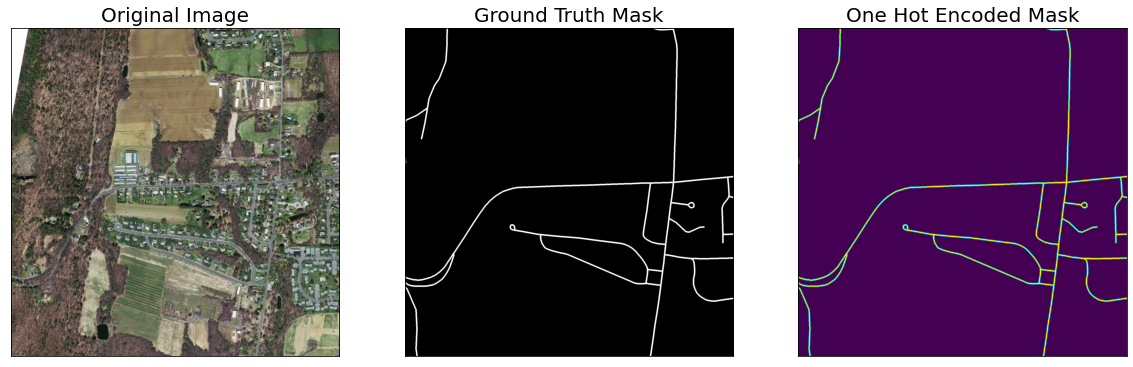

In [10]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

###  Аугментация

In [26]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### визуализируем аугментацию

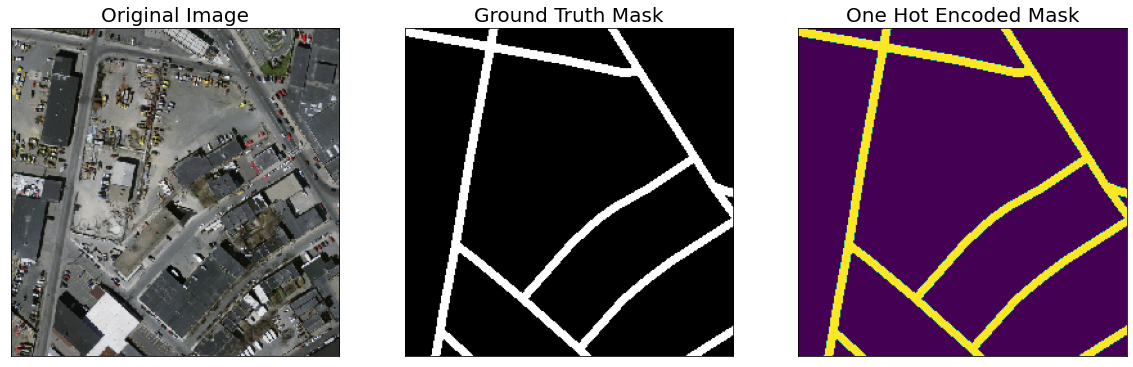

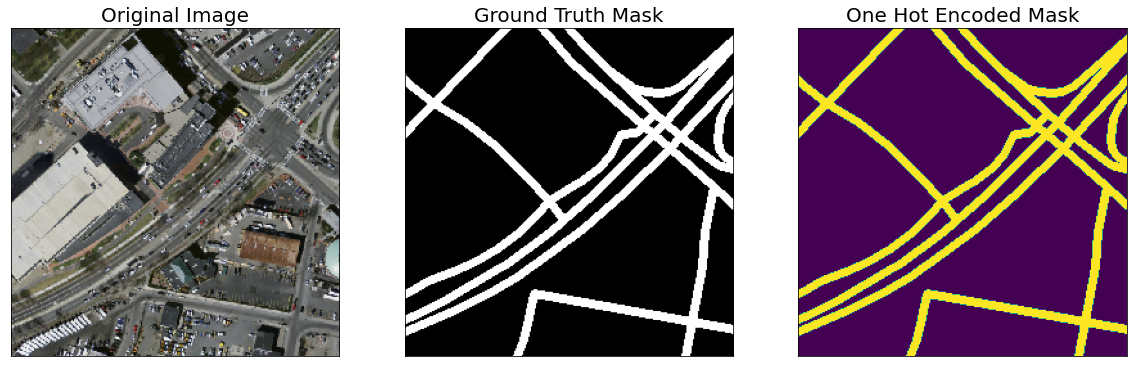

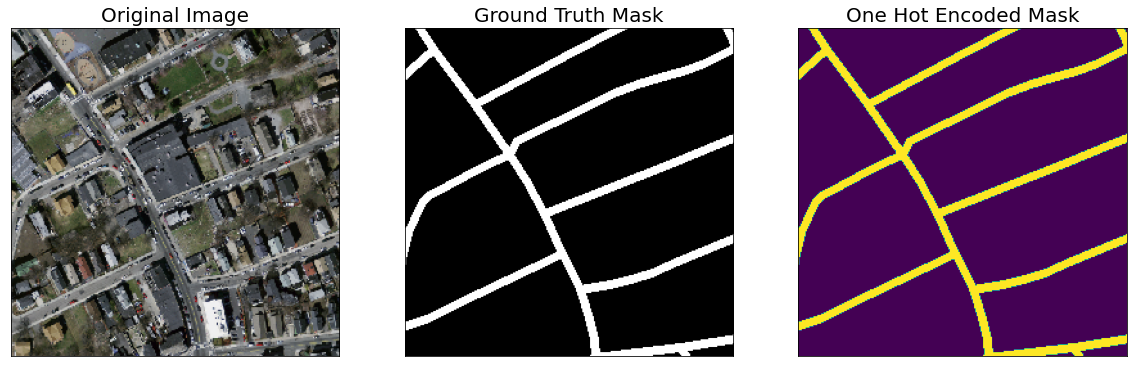

In [27]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training UNet

<h3><center>UNet Model Architecture</center></h3>
<img src="https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1505.04597">Image Courtesy: UNet [Ronneberger et al.]</a></center></h4>

### Model Definition

In [28]:
# ENCODER = 'resnet50'
# ENCODER_WEIGHTS = 'imagenet'
# CLASSES = select_classes
# ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# # create segmentation model with pretrained encoder
# model = smp.Unet(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [29]:
from typing import Optional, Union, List

from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import (
    SegmentationModel,
    SegmentationHead,
    ClassificationHead,
)
# from .decoder import UnetPlusPlusDecoder


class UnetPlusPlus(SegmentationModel):
    """Unet++ is a fully convolution neural network for image semantic segmentation. Consist of *encoder*
    and *decoder* parts connected with *skip connections*. Encoder extract features of different spatial
    resolution (skip connections) which are used by decoder to define accurate segmentation mask. Decoder of
    Unet++ is more complex than in usual Unet.

    Args:
        encoder_name: Name of the classification model that will be used as an encoder (a.k.a backbone)
            to extract features of different spatial resolution
        encoder_depth: A number of stages used in encoder in range [3, 5]. Each stage generate features
            two times smaller in spatial dimensions than previous one (e.g. for depth 0 we will have features
            with shapes [(N, C, H, W),], for depth 1 - [(N, C, H, W), (N, C, H // 2, W // 2)] and so on).
            Default is 5
        encoder_weights: One of **None** (random initialization), **"imagenet"** (pre-training on ImageNet) and
            other pretrained weights (see table with available weights for each encoder_name)
        decoder_channels: List of integers which specify **in_channels** parameter for convolutions used in decoder.
            Length of the list should be the same as **encoder_depth**
        decoder_use_batchnorm: If **True**, BatchNorm2d layer between Conv2D and Activation layers
            is used. If **"inplace"** InplaceABN will be used, allows to decrease memory consumption.
            Available options are **True, False, "inplace"**
        decoder_attention_type: Attention module used in decoder of the model.
            Available options are **None** and **scse** (https://arxiv.org/abs/1808.08127).
        in_channels: A number of input channels for the model, default is 3 (RGB images)
        classes: A number of classes for output mask (or you can think as a number of channels of output mask)
        activation: An activation function to apply after the final convolution layer.
            Available options are **"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"tanh"**, **"identity"**,
                **callable** and **None**.
            Default is **None**
        aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is build
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax"
                    (could be **None** to return logits)

    Returns:
        ``torch.nn.Module``: **Unet++**

    Reference:
        https://arxiv.org/abs/1807.10165

    """

    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        if encoder_name.startswith("mit_b"):
            raise ValueError("UnetPlusPlus is not support encoder_name={}".format(encoder_name))

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetPlusPlusDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(in_channels=self.encoder.out_channels[-1], **aux_params)
        else:
            self.classification_head = None

        self.name = "unetplusplus-{}".format(encoder_name)
        self.initialize()
        
import torch
import torch.nn as nn
import torch.nn.functional as F

from segmentation_models_pytorch.base import modules as md


class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = md.Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetPlusPlusDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        self.in_channels = [head_channels] + list(decoder_channels[:-1])
        self.skip_channels = list(encoder_channels[1:]) + [0]
        self.out_channels = decoder_channels
        if center:
            self.center = CenterBlock(head_channels, head_channels, use_batchnorm=use_batchnorm)
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)

        blocks = {}
        for layer_idx in range(len(self.in_channels) - 1):
            for depth_idx in range(layer_idx + 1):
                if depth_idx == 0:
                    in_ch = self.in_channels[layer_idx]
                    skip_ch = self.skip_channels[layer_idx] * (layer_idx + 1)
                    out_ch = self.out_channels[layer_idx]
                else:
                    out_ch = self.skip_channels[layer_idx]
                    skip_ch = self.skip_channels[layer_idx] * (layer_idx + 1 - depth_idx)
                    in_ch = self.skip_channels[layer_idx - 1]
                blocks[f"x_{depth_idx}_{layer_idx}"] = DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
        blocks[f"x_{0}_{len(self.in_channels)-1}"] = DecoderBlock(
            self.in_channels[-1], 0, self.out_channels[-1], **kwargs
        )
        self.blocks = nn.ModuleDict(blocks)
        self.depth = len(self.in_channels) - 1

    def forward(self, *features):

        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder
        # start building dense connections
        dense_x = {}
        for layer_idx in range(len(self.in_channels) - 1):
            for depth_idx in range(self.depth - layer_idx):
                if layer_idx == 0:
                    output = self.blocks[f"x_{depth_idx}_{depth_idx}"](features[depth_idx], features[depth_idx + 1])
                    dense_x[f"x_{depth_idx}_{depth_idx}"] = output
                else:
                    dense_l_i = depth_idx + layer_idx
                    cat_features = [dense_x[f"x_{idx}_{dense_l_i}"] for idx in range(depth_idx + 1, dense_l_i + 1)]
                    cat_features = torch.cat(cat_features + [features[dense_l_i + 1]], dim=1)
                    dense_x[f"x_{depth_idx}_{dense_l_i}"] = self.blocks[f"x_{depth_idx}_{dense_l_i}"](
                        dense_x[f"x_{depth_idx}_{dense_l_i-1}"], cat_features
                    )
        dense_x[f"x_{0}_{self.depth}"] = self.blocks[f"x_{0}_{self.depth}"](dense_x[f"x_{0}_{self.depth-1}"])
        return dense_x[f"x_{0}_{self.depth}"]

In [30]:
UnetPlusPlus

__main__.UnetPlusPlus

In [31]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Get Train / Val DataLoaders

In [32]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

#### Set Hyperparams

In [33]:
from segmentation_models_pytorch import utils as smp_utils

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")

# define loss function
loss = smp_utils.losses.DiceLoss()

# define metrics
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# # load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [34]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training UNet

In [35]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s, dice_loss - 0.3489, iou_score - 0.7746]
Model saved!

Epoch: 1
valid: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s, dice_loss - 0.2661, iou_score - 0.8508]
Model saved!

Epoch: 2
valid: 100%|██████████| 14/14 [00:06<00:00,  2.14it/s, dice_loss - 0.207, iou_score - 0.8776] 
Model saved!

Epoch: 3
valid: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s, dice_loss - 0.1691, iou_score - 0.8772]

Epoch: 4
valid: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s, dice_loss - 0.1403, iou_score - 0.881] 
Model saved!

Epoch: 5
valid: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s, dice_loss - 0.1199, iou_score - 0.8879]
Model saved!

Epoch: 6
valid: 100%|██████████| 14/14 [00:06<00:00,  2.14it/s, dice_loss - 0.1096, iou_score - 0.8867]

Epoch: 7
valid: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s, dice_loss - 0.09891, iou_score - 0.8892]
Model saved!

Epoch: 8
valid: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s, dice_loss - 0.09

### Prediction on Test Data

In [37]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# # load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
#     best_model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


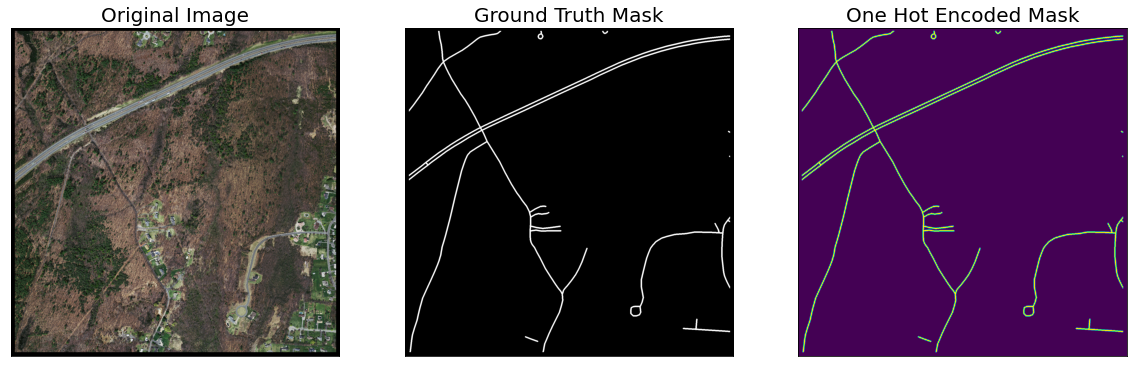

In [38]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [39]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [40]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [41]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
#     cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
#     visualize(
#         original_image = image_vis,
#         ground_truth_mask = gt_mask,
#         predicted_mask = pred_mask,
#         predicted_road_heatmap = pred_road_heatmap
#     )

### Model Evaluation on Test Dataset

In [42]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s, dice_loss - 0.05362, iou_score - 0.9142]
Evaluation on Test Data: 
Mean IoU Score: 0.9142
Mean Dice Loss: 0.0536


### Plot Dice Loss & IoU Metric for Train vs. Val

In [43]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dice_loss,0.375797,0.278141,0.214497,0.165748,0.127938,0.103539,0.087699,0.076108,0.067811,0.061678,0.055667,0.051093,0.047550,0.046212,0.042921,0.041536,0.040381,0.040022,0.037610,0.036813
iou_score,0.723792,0.889472,0.921705,0.931328,0.937896,0.941392,0.941524,0.943592,0.943600,0.943264,0.945698,0.947160,0.947979,0.945643,0.948040,0.947209,0.946663,0.944878,0.947296,0.946998


In [44]:
valid_logs_df

,dice_loss,iou_score
0,0.348919,0.774551
1,0.266102,0.850773
2,0.207036,0.877564
3,0.169137,0.877221
4,0.140341,0.881002
5,0.119882,0.887918
6,0.109579,0.886713
7,0.098906,0.889219
8,0.092252,0.889852
9,0.087006,0.890479


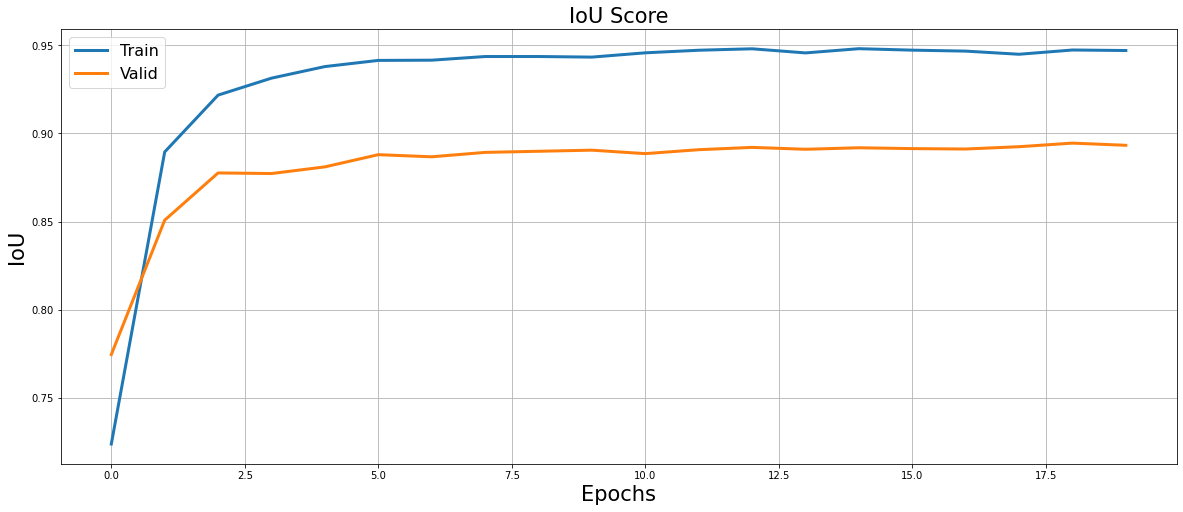

In [45]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU', fontsize=21)
plt.title('IoU Score', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()